# Imports and auxiliary functions for plotting

In [1]:
import pandas as pd
import numpy as np
import io
import re

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns; sns.set(); sns.set(font_scale=1.0); sns.set_style("white"); 

import matplotlib as mpl
from matplotlib import pyplot as plt
#%matplotlib inline

def _reset_mpl_config(font_size = 17*1.5, cmbright=True):
    mpl.rcParams.update(mpl.rcParamsDefault) #reset to defaults
        
    SMALL_SIZE = font_size-4
    MEDIUM_SIZE = font_size
    BIGGER_SIZE = font_size
    
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    plt.rc('font',**{'family':'serif','serif':['Times'], "weight": "normal"})
    plt.rc('text', usetex=True)
    plt.rc('mathtext', fontset='stix')  #['dejavusans', 'dejavuserif', 'cm', 'stix', 'stixsans', 'custom']
    
    mpl.rcParams['text.latex.preamble'] = [
            r'\usepackage{mathtools}',
            r'\usepackage{amsmath}',
            r'\usepackage{amsfonts}', 
            r'\usepackage{microtype}',    
            r'\usepackage{arydshln}',              
    ] + ([r'\usepackage{cmbright}'] if cmbright else [])

def _create_fig(bottom=0.2, left=0.125, right=0.9, top=0.9):
    fig = plt.figure(figsize=(6.4, 4.8), dpi=72)
    fig.subplots_adjust(bottom=bottom, left=left, right=right, top=top) 
    
    
def start_plotting(cmbright=True, font_size=17*1.5, bottom=0.2, left=0.125, right=0.95, top=0.95):
    _reset_mpl_config(cmbright=cmbright, font_size=font_size)
    _create_fig(bottom=bottom, left=left, right=right, top=top)

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from matplotlib import pyplot as plt 
import numpy as np

def running_mean(x, N=5):
    x = list(x)
    l = N//2    
    return [np.mean(x[max(i-l,0): min(i+l+1, len(x))]) for i in range(len(x))]

def errorfill(x, y, yerr, color=None, alpha_fill=0.2, ax=None, label="", lw=2, ls="-"):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    ax.plot(x, running_mean(y), color=color, label=label, lw=lw, ls=ls)
    ax.fill_between(x, running_mean(ymax), running_mean(ymin), color=color, alpha=alpha_fill, linewidth=0.0)
    
    
def extract_mean_std(df, x, y):
    df = df.sort_values(x)
    return df.groupby(x).mean().index, df.groupby(x).mean()[y], df.groupby(x).std()[y]    

In [5]:
def sm(x, N=7):
    l = N//2    
    return [np.mean(x[max(i-l,0): min(i+l+1, len(x))]) for i in range(len(x))]

# Results loading and processing

In [6]:
COLS = dict(enumerate("FILE, t, logu, SEED, epoch, elbo, training_rmse, training_qrisk, training_erisk, training_qgain, training_egain".split(", ")))

In [7]:
def parse_method(v):
    method = v.split("_")[1]
    if method=="LCVIEM":
        method+=v.split("_")[6]+v.split("_")[7]
    return method

In [8]:
results_str = "\n".join(l.replace(":", ",") for l in open("RESULTS/RESULTS.csv").readlines()) 
df = pd.read_csv( io.StringIO(results_str), header=None).rename(columns=COLS)

In [9]:
dvi = df[df.logu=="VI"]
dlcvi = df[df.logu=="utility_term_linearized"]

In [10]:
XCOL = "epoch"
COL = "training_erisk"

In [11]:
dvi = dvi[dvi.epoch==30000].groupby("SEED").first().reset_index()
seed2vi_value = dict(zip(dvi["SEED"], dvi[COL]))

def update(d):
    d[COL] = [ (100* (seed2vi_value[seed]-v)/seed2vi_value[seed]) for v, seed in zip(d[COL], d["SEED"])]
    
update(dlcvi)    

# Plots

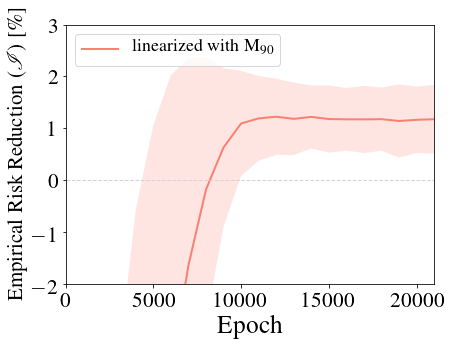

In [12]:
start_plotting(cmbright=False, font_size=17*1.5, left=0.15)
x,y,yerr = extract_mean_std(dlcvi, XCOL, COL)
errorfill(x,y,yerr, color="salmon", ls="-", label="linearized with M$_{90}$")

    
plt.ylim(-2,3)
plt.axhline(0, color="lightgray", ls="--", lw=1)
plt.xlim(0,21000)
plt.legend(loc=2, fontsize=18)
plt.xlabel("Epoch")
plt.ylabel("Empirical Risk Reduction ($\mathcal{I}$) [\%]", fontsize=21)
plt.savefig("8schools_improvement_iterations.pdf")
plt.show()